In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics

In [2]:
using ProgressMeter, SpecialFunctions


In [3]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [4]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [5]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == -1 # the simplest agent
        opponent_history = []
    end
    if depth <= 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [6]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [8]:
function run_two_agents_theory_of_mind(my_model, other_model, opponent_prior, my_prior, opponent_history, my_history, depth, show_progress = true)
    second_chn_i = []
    first_chn_i = []
    p = Progress(depth)
    if depth == -1
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, -1),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, -1), INFALG, N , progress = false) 
    end 
    for i in 0:depth
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, i),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, i), INFALG, N , progress = false)
        if show_progress
            ProgressMeter.next!(p)
        end
    end
    return second_chn_i
end

run_two_agents_theory_of_mind (generic function with 2 methods)

D = gammaln(sum(alpha)) – gammaln(sum(beta)) – sum(gammaln(alpha)) + …
sum(gammaln(beta)) + (alpha – beta) * (psi(alpha) – psi(sum(alpha)))’;

In [7]:
function show_results(chain)
    plotChn(chain)
end

show_results (generic function with 1 method)

## Depth 0

In [29]:
chain = run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,9,2], [], [], -1)

7.154852354927435

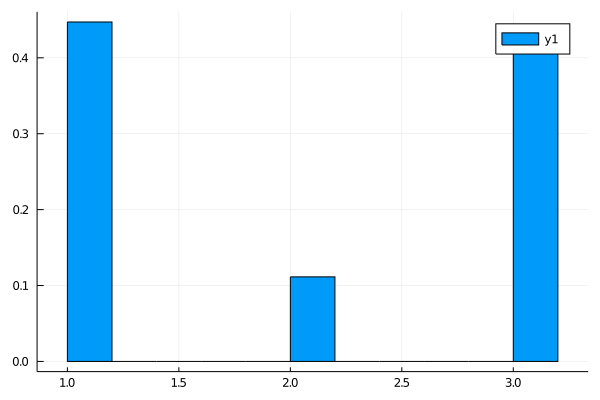

In [37]:
show_results(chain)

In [39]:
chain = run_two_agents_theory_of_mind(agent, agent, [1,9,2] , [1,9,2], [], [], -1)

Chains MCMC chain (10000×6×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters      mean       std   naive_se      mcse          ess      rha ⋯
         Symbol   Float64   Float64    Float64   Float64      Float64   Float6 ⋯

    beta_opp[1]    0.0835    0.0769     0.0008    0.0007    9794.4131    1.000 ⋯
    beta_opp[2]    0.7491    0.1199     0.0012    0.0011    9619.1302    1.000 ⋯
    beta_opp[3]    0.1674    0.1044     0.0010    0.0009   10080.5907    0.999 ⋯
        my_move    2.5413    0.7797     0.0078    0.0084   10119.2696    0.999 ⋯
  next_opp_move    2.0900    0.4915     0.0049    0.0049   10027.1964    0.999 ⋯
                                                                1 column omitted

Quantiles
     parameters      2.5%     25.0%     50.0

10.705832668674233

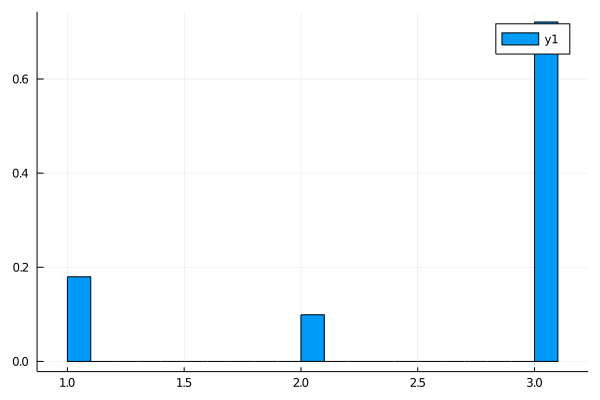

In [40]:
show_results(chain)

7.272742702856028

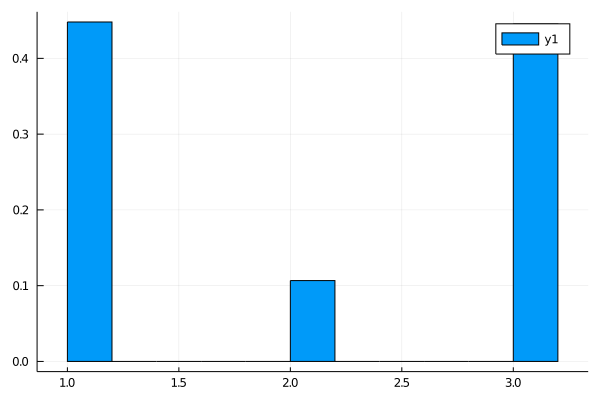

In [41]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

7.197697575012887

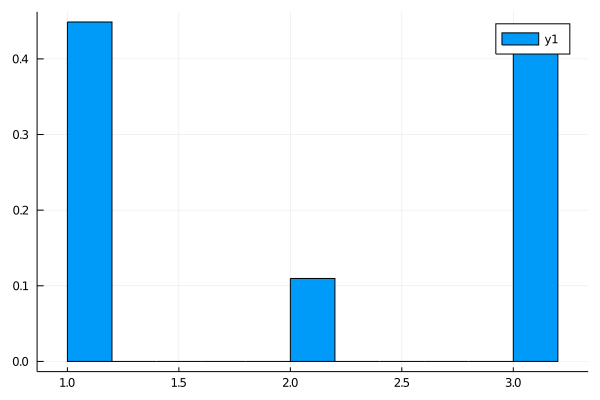

In [42]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

1.460436006513103

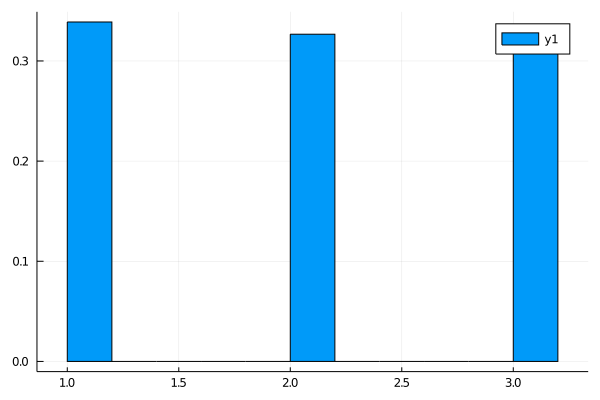

In [43]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 0))

## Depth 3

In [51]:
chain = run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 3)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.0919      0.0838     0.0008    0.0008    9357.7029    1 ⋯
    beta_opp[2]      0.4535      0.1419     0.0014    0.0015   10264.6762    1 ⋯
    beta_opp[3]      0.4546      0.1425     0.0014    0.0015   10141.3900    1 ⋯
            idx   4960.4445   2893.6800    28.9368   28.3146    9329.6725    1 ⋯
        my_move      1.9811      0.8682     0.0087    0.0080   10288.2986    1 ⋯
  next_opp_move      2.1487      0.7798     0.0078    0.0077    9686.2533    0 ⋯
                                                  

1.4603204304862887

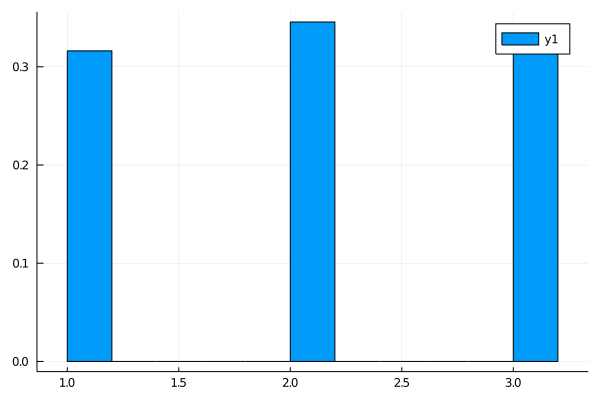

In [45]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 3,false))

## Depth 10

Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


7.095887383817027

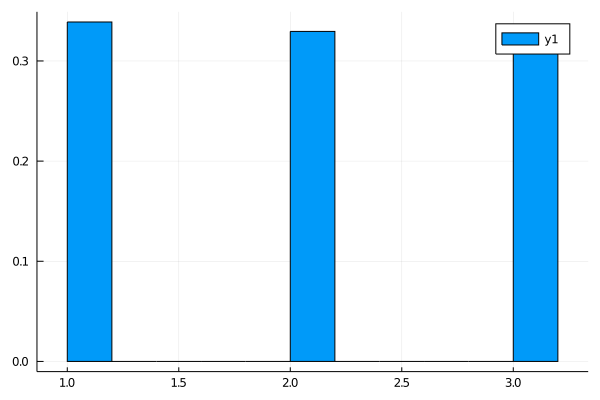

In [46]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 10))

In [47]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 10))

Progress:  60%|█████████████████████████                |  ETA: 0:00:37

LoadError: InterruptException:

## Depth 20

In [48]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 20))

LoadError: InterruptException:

In [49]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 20))

Progress:   5%|███                                      |  ETA: 0:00:56

LoadError: InterruptException:

# Simulations

In [9]:
function sample_move(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:my_move][idx, 1]
    return move_sample
end

sample_move (generic function with 1 method)

In [10]:
function move(agent, other_agent, other_agent_history, my_history, other_player_prior, my_depth=1)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    my_history = length(my_history) > 0 ? my_history : [1]
    my_history = Array{Int}(my_history)
    m = agent(other_agent, other_agent_history, other_player_prior, my_depth)
    chain = run_two_agents_theory_of_mind(agent, other_agent, other_player_prior, [1,1,1] , other_agent_history, my_history, my_depth, false)
    return sample_move(chain), chain
end

move (generic function with 2 methods)

In [28]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1])
    first_player = agent
    second_player = agent
    num_of_rounds = 5
    first_player_history = []
    second_player_history = []
    first_player_theoretical_score = []
    
    @showprogress for i in 1:num_of_rounds
        m1, chain1 = move(first_player, second_player, second_player_history, first_player_history, second_player_prior_policy, first_player_depth)
        push!(first_player_history, m1)
        m2, chain2 = move(second_player, first_player, first_player_history, second_player_history, first_player_prior_policy, second_player_depth)
        push!(second_player_history, m2)
        
        ts = compute_theoretical_score(chain1, chain2)
        push!(first_player_theoretical_score, ts)
    end
    return first_player_history, second_player_history, first_player_theoretical_score
 end

game (generic function with 5 methods)

In [12]:
function score(history)
    first_player_history, second_player_history , _ = history
    first_wins = 0
    ties = 0
    second_wins = 0
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
    end
    return [first_wins, ties, second_wins]
end

score (generic function with 1 method)

In [13]:
NUM_OF_MC_SIMULATIONS = 10000
function mc_simulation(first_policy, second_policy)
    first_weights = Weights(first_policy/sum(first_policy))
    first_moves = sample(collect(1:length(first_weights)), first_weights, NUM_OF_MC_SIMULATIONS)
    second_weights = Weights(second_policy/sum(second_policy))
    second_moves = sample(collect(1:length(second_weights)), second_weights, NUM_OF_MC_SIMULATIONS)
    first, tie, second = score([first_moves, second_moves, [], []])
    return (first - second) / NUM_OF_MC_SIMULATIONS
end

mc_simulation (generic function with 1 method)

In [14]:
function compute_theoretical_score(first_chain, second_chain)
    first_weights = exp.(first_chain[:lp][:, 1])
    first_weights = Weights(first_weights/sum(first_weights))
    first_sampled_moves = sample(first_chain[:my_move], first_weights, NUM_OF_MC_SIMULATIONS)
    second_weights = exp.(second_chain[:lp][:, 1])
    second_weights = Weights(second_weights/sum(second_weights))
    second_sampled_moves = sample(second_chain[:my_move], second_weights, NUM_OF_MC_SIMULATIONS)
    first, tie, second = score([first_sampled_moves, second_sampled_moves, []])
    return (first - second) / NUM_OF_MC_SIMULATIONS
end

compute_theoretical_score (generic function with 1 method)

In [15]:
function accumulated_score(history)
    first_player_history, second_player_history , _ = history
    first_wins, ties, second_wins = 0, 0, 0
    acc_result = []
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
        push!(acc_result, [first_wins, ties, second_wins])
    end
    return acc_result
end

accumulated_score (generic function with 1 method)

In [16]:
function plot_accumulated_score(acc_result)
    n = length(acc_result)
    acc_result = transpose(reduce(hcat, acc_result))
    plot(1:n, acc_result, alpha = 0.3)
end

plot_accumulated_score (generic function with 1 method)

In [17]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

In [18]:
NUM_OF_EXPIREMENTS = 30

30

In [19]:
function mean_and_var(results)
    results = reduce(hcat, results)
    mean_results = mean(results,dims=2)
    var_results = std(results,dims=2)
    return mean_results , var_results
end

mean_and_var (generic function with 1 method)

In [20]:
function simulate_game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10)
    result_plt = plot(title = "Game Results")
    ts_plt = plot(title = "Score Based on MC Simulations")
    scores = []
    for i in 1:num_of_expirements
        game_result = game(first_player_depth,second_player_depth, first_player_prior_policy, second_player_prior_policy)
        acc_result = accumulated_score(game_result)
        score_result = score(game_result)
        push!(scores,score_result)
        n = length(acc_result)
        acc_result = transpose(reduce(hcat, acc_result))
        plot!(result_plt, acc_result, alpha = 0.3, legend = false, label = ["p1 wins" "ties" "p2 wins"] , color = [1 2 3])
        
        _ , _ , ts_score = game_result
        plot!(ts_plt, ts_score , alpha = 0.3, legend = false, color = [1])
    end
    display(result_plt)
    mean_results, var_results = mean_and_var(scores)
    println("first win: $(mean_results[1])+-$(var_results[1])")
    println("ties: $(mean_results[2])+-$(var_results[2])")
    println("second win: $(mean_results[3])+-$(var_results[3])")
    display(ts_plt)
end 

simulate_game (generic function with 6 methods)

In [31]:
using PyPlot
function simulate_grid(first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10)
    fig, axs = subplots(6, 6, sharey=true, sharex=true) 
    fig.suptitle("Score Based on MC Simulations")
    for my_depth in -1:4
       for opponent_depth in -1:my_depth
            println("opponent_depth #$opponent_depth my_depth #$my_depth")
            for i in 1:num_of_expirements
                println("expirment #$i")
                game_result = game(my_depth, opponent_depth, first_player_prior_policy, second_player_prior_policy)
                _, _ , mc_score = game_result
                axs[my_depth+2, opponent_depth+2].plot(mc_score, alpha=0.1, color="blue")
            end
        end
    end
end

simulate_grid (generic function with 4 methods)

opponent_depth #-1 my_depth #-1
expirment #1

Progress:  20%|█████████                                |  ETA: 0:00:20

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


opponent_depth #-1 my_depth #0
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


opponent_depth #0 my_depth #0
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


opponent_depth #-1 my_depth #1
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


opponent_depth #0 my_depth #1
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21

expirment #2



Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


opponent_depth #1 my_depth #1
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:02:45


opponent_depth #-1 my_depth #2
expirment #1

Progress:  20%|█████████                                |  ETA: 0:02:07

Progress: 100%|█████████████████████████████████████████| Time: 0:02:28


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


opponent_depth #0 my_depth #2
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:02:29


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:02:28


opponent_depth #1 my_depth #2
expirment #1

Progress:  20%|█████████                                |  ETA: 0:02:38

Progress: 100%|█████████████████████████████████████████| Time: 0:03:24


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:03:27


opponent_depth #2 my_depth #2
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:04:16


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:04:13


opponent_depth #-1 my_depth #3
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


expirment #2

Progress:  20%|█████████                                |  ETA: 0:02:32

Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


opponent_depth #0 my_depth #3
expirment #1

Progress:  20%|█████████                                |  ETA: 0:02:39

Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:03:25


opponent_depth #1 my_depth #3
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:04:02


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:03:48


opponent_depth #2 my_depth #3
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:04:34


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:04:42


opponent_depth #3 my_depth #3
expirment #1

Progress:  20%|█████████                                |  ETA: 0:04:24

Progress: 100%|█████████████████████████████████████████| Time: 0:05:09


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:04:52


opponent_depth #-1 my_depth #4
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:03:16


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


opponent_depth #0 my_depth #4
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:03:23


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


opponent_depth #1 my_depth #4
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:04:23


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:04:51


opponent_depth #2 my_depth #4
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:05:35


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:05:03


opponent_depth #3 my_depth #4
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:05:57


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:06:05


opponent_depth #4 my_depth #4
expirment #1


Progress: 100%|█████████████████████████████████████████| Time: 0:07:08


expirment #2


Progress: 100%|█████████████████████████████████████████| Time: 0:05:56


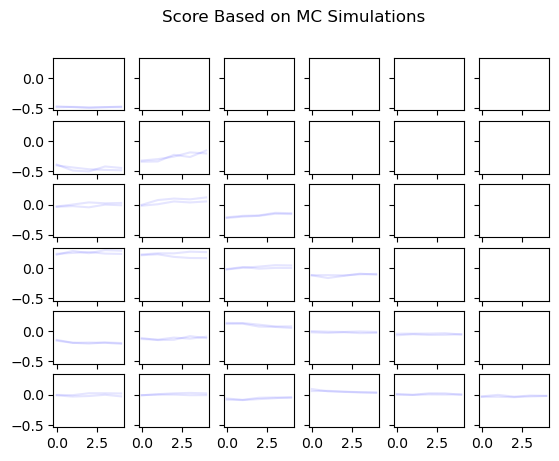

In [32]:
simulate_grid([1,10,1], [1,1,10], 2)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:34
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:34
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35
Progress: 100%|█████████████████████████████████████████| Time: 

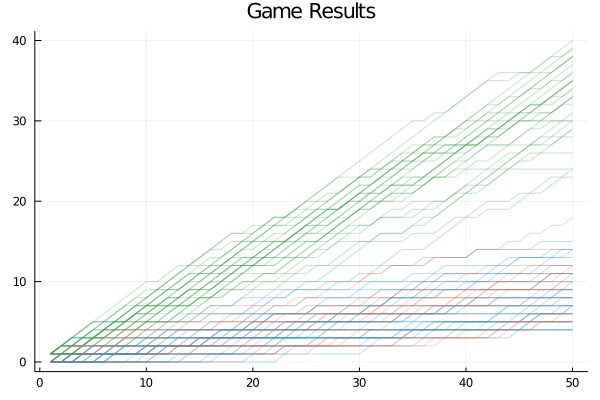

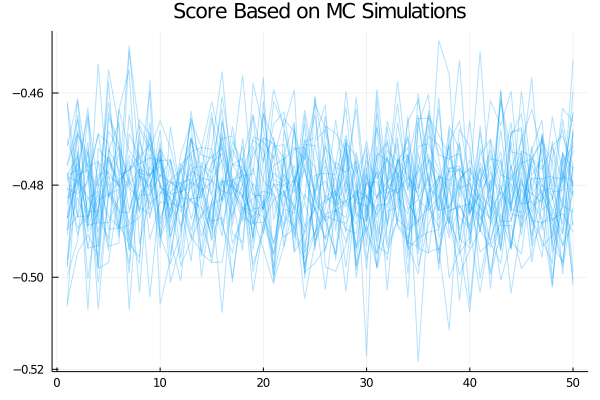

first win: 8.533333333333333+-3.2982057121320114
ties: 8.666666666666666+-3.219909329772195
second win: 32.8+-4.722652673642438


In [118]:
simulate_game(-1, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:39
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:38
Progress: 100%|█████████████████████████████████████████| Time: 0:02:36
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:39
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 

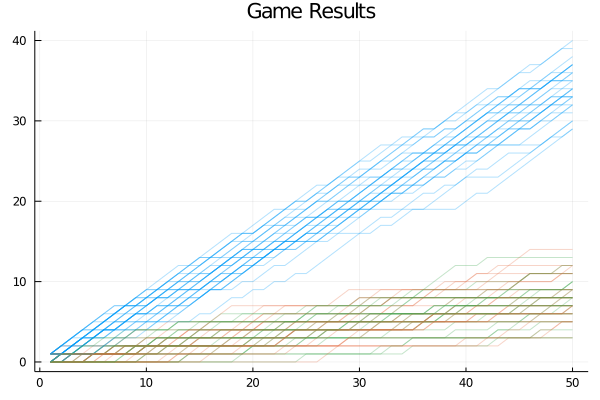

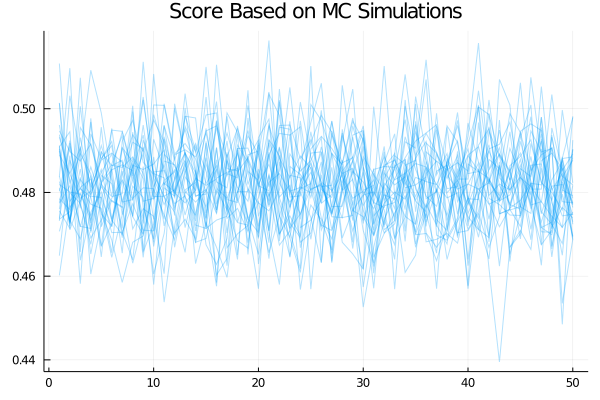

first win: 34.13333333333333+-2.849480694773182
ties: 8.066666666666666+-2.585547808736935
second win: 7.8+-2.4551142960963244


In [117]:
simulate_game(-1, -1, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 0:03:22
Progress: 100%|█████████████████████████████████████████| Time: 

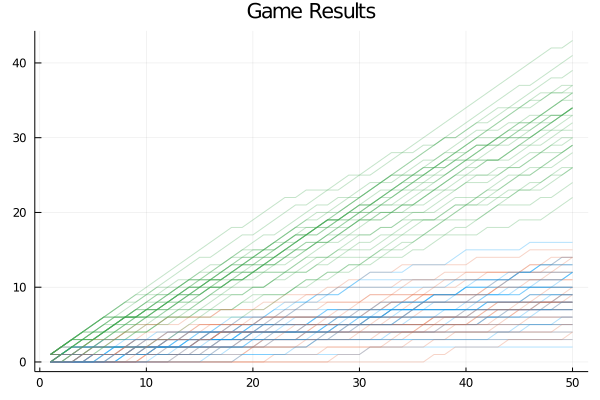

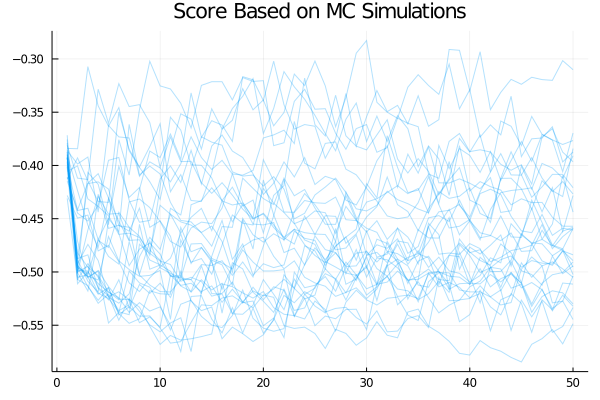

first win: 8.7+-3.333735607910183
ties: 8.9+-3.2626411978957934
second win: 32.4+-4.92425383810268


In [119]:
simulate_game(0, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 

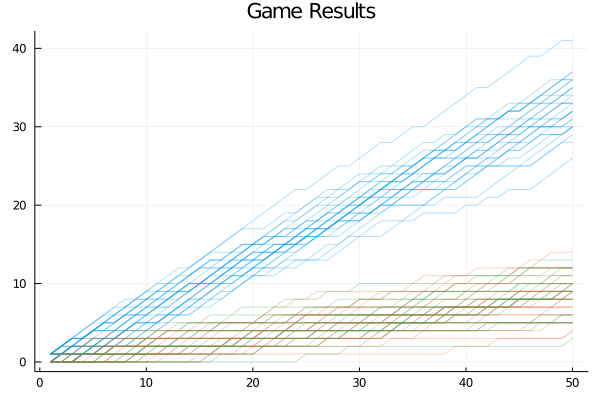

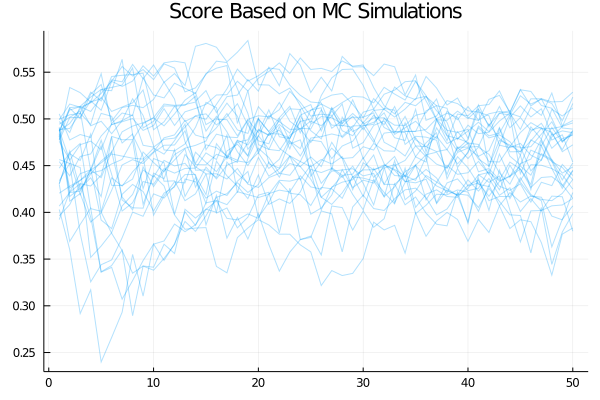

first win: 32.9+-3.1769645022058177
ties: 8.3+-2.534588315887707
second win: 8.8+-2.5243640373574188


In [120]:
simulate_game(-1, 0, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 

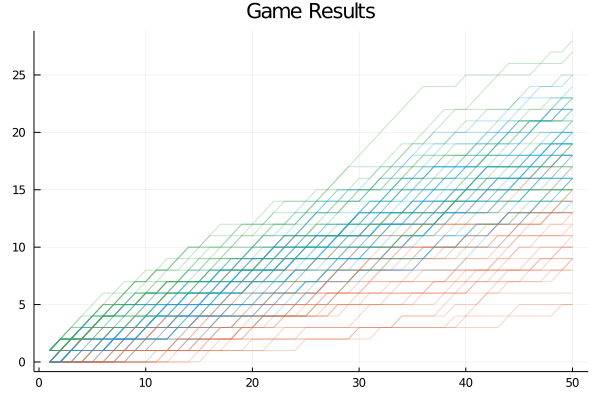

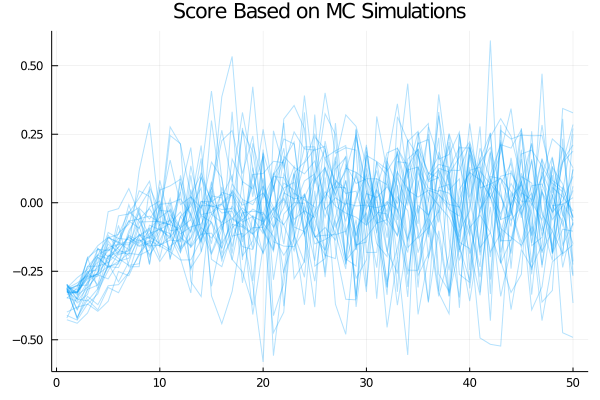

first win: 19.0+-2.9942473580817115
ties: 11.666666666666666+-3.651483716701107
second win: 19.333333333333332+-3.7813820984810094


In [121]:
simulate_game(0, 0, [1,10,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:07
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:09
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 

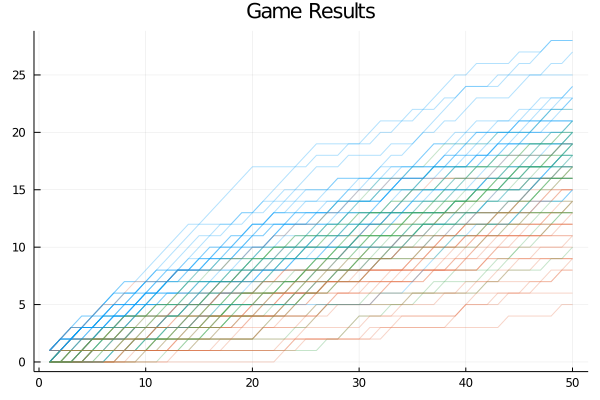

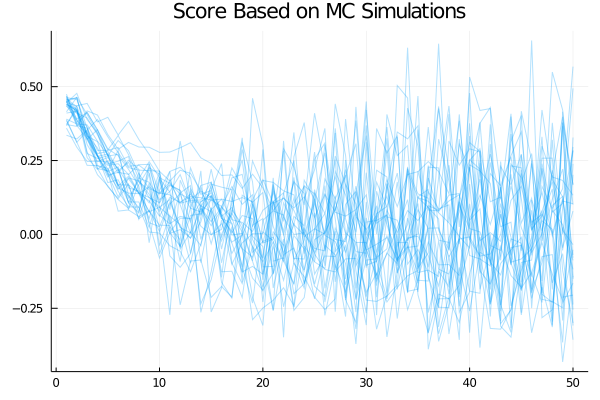

first win: 20.733333333333334+-3.4931789033163927
ties: 12.233333333333333+-3.4208622963479125
second win: 17.033333333333335+-2.8464537323790657


In [122]:
simulate_game(0, 0, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:09:42
Progress: 100%|█████████████████████████████████████████| Time: 0:09:43
Progress: 100%|█████████████████████████████████████████| Time: 0:09:35
Progress: 100%|█████████████████████████████████████████| Time: 0:09:36
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 

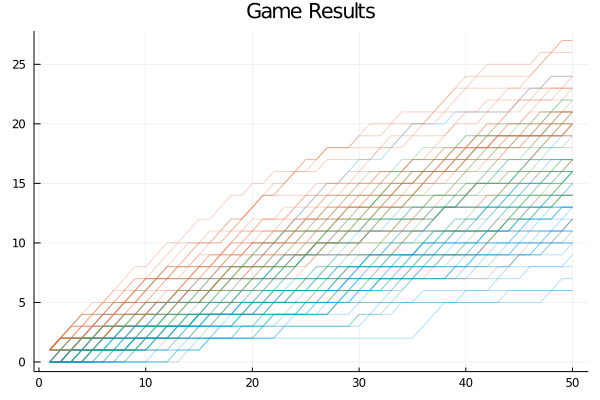

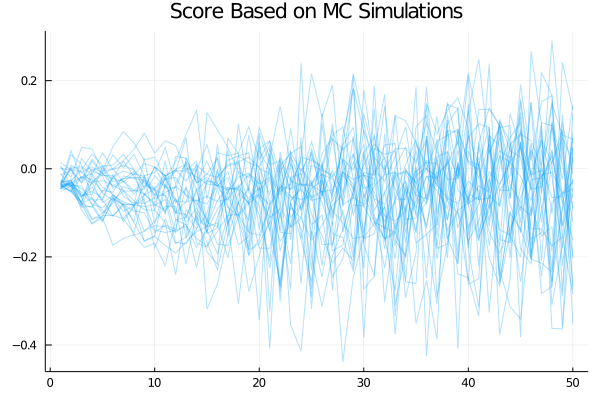

first win: 12.5+-3.8573709109738963
ties: 20.566666666666666+-3.6829835481701454
second win: 16.933333333333334+-2.778406059215437


In [123]:
simulate_game(0, 1, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(1, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:08:55
Progress: 100%|█████████████████████████████████████████| Time: 0:08:34
Progress: 100%|█████████████████████████████████████████| Time: 0:08:40
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:36
Progress: 100%|█████████████████████████████████████████| Time: 0:08:38
Progress: 100%|█████████████████████████████████████████| Time: 0:08:38
Progress: 100%|█████████████████████████████████████████| Time: 0:08:41
Progress: 100%|█████████████████████████████████████████| Time: 0:09:41
Progress: 100%|█████████████████████████████████████████| Time: 0:10:28
Progress: 100%|█████████████████████████████████████████| Time: 0:11:59
Progress: 100%|█████████████████████████████████████████| Time: 0:09:21
Progress: 100%|█████████████████████████████████████████| Time: 0:12:08
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:37
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:10:53
Progress: 100%|█████████████████████████████████████████| Time: 0:11:54
Progress: 100%|█████████████████████████████████████████| Time: 0:12:48
Progress: 100%|█████████████████████████████████████████| Time: 0:12:21
Progress: 100%|█████████████████████████████████████████| Time: 

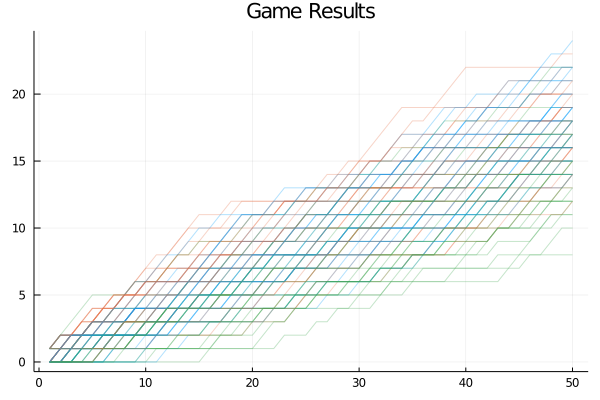

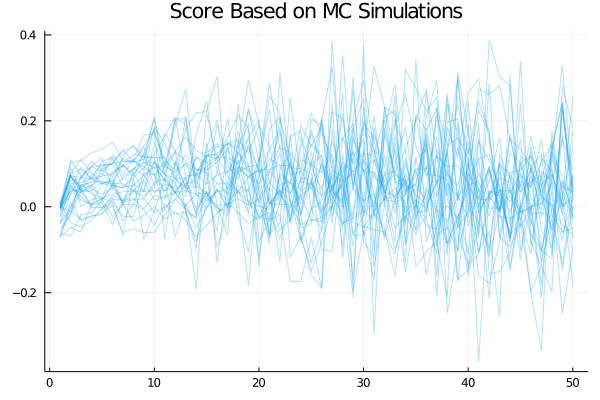

first win: 18.1+-2.6043729803332036
ties: 17.366666666666667+-2.7226170641794116
second win: 14.533333333333333+-2.932967584303433


In [124]:
simulate_game(1, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:21
Progress: 100%|█████████████████████████████████████████| Time: 0:15:16
Progress: 100%|█████████████████████████████████████████| Time: 0:15:23
Progress: 100%|█████████████████████████████████████████| Time: 0:15:26
Progress: 100%|█████████████████████████████████████████| Time: 0:15:16
Progress: 100%|█████████████████████████████████████████| Time: 0:15:22
Progress: 100%|█████████████████████████████████████████| Time: 0:15:16
Progress: 100%|█████████████████████████████████████████| Time: 0:15:27
Progress: 100%|█████████████████████████████████████████| Time: 0:15:14
Progress: 100%|█████████████████████████████████████████| Time: 0:15:24
Progress: 100%|█████████████████████████████████████████| Time: 0:15:15
Progress: 100%|█████████████████████████████████████████| Time: 0:15:32
Progress: 100%|█████████████████████████████████████████| Time: 0:15:23
Progress: 100%|█████████████████████████████████████████| Time: 

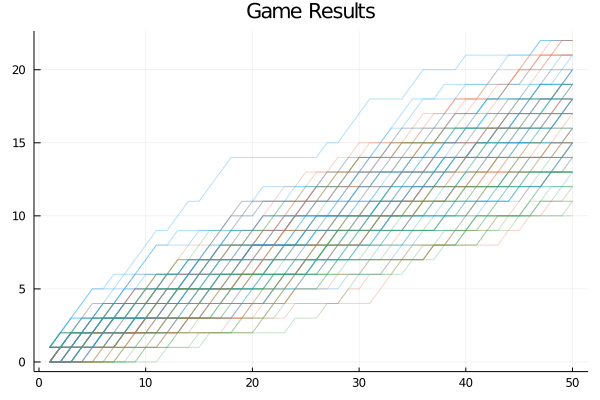

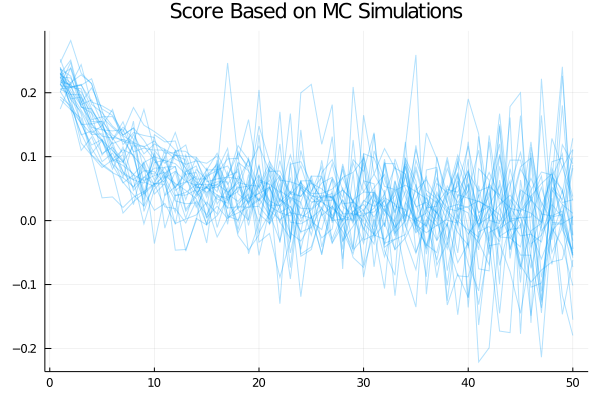

first win: 17.733333333333334+-2.5988503205274736
ties: 17.7+-2.8785772347727137
second win: 14.566666666666666+-2.582211473128029


In [125]:
simulate_game(1, 1, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:53
Progress: 100%|█████████████████████████████████████████| Time: 0:15:26
Progress: 100%|█████████████████████████████████████████| Time: 0:15:16
Progress: 100%|█████████████████████████████████████████| Time: 0:15:25
Progress: 100%|█████████████████████████████████████████| Time: 0:15:13
Progress: 100%|█████████████████████████████████████████| Time: 0:15:27
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:16
Progress: 100%|█████████████████████████████████████████| Time: 0:15:26
Progress: 100%|█████████████████████████████████████████| Time: 0:15:26
Progress: 100%|█████████████████████████████████████████| Time: 0:15:22
Progress: 100%|█████████████████████████████████████████| Time: 

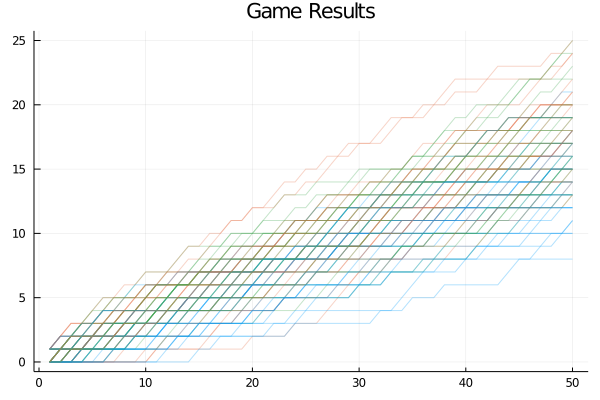

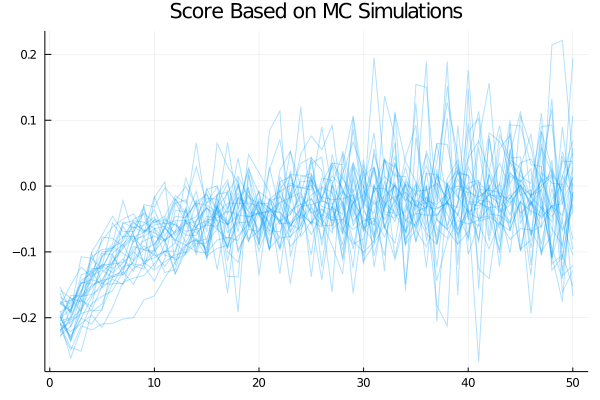

first win: 14.166666666666666+-2.865771044267305
ties: 18.2+-3.263169603632175
second win: 17.633333333333333+-3.101538365051294


In [126]:
simulate_game(1, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:21
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:20
Progress: 100%|█████████████████████████████████████████| Time: 0:15:22
Progress: 100%|█████████████████████████████████████████| Time: 0:15:41
Progress: 100%|█████████████████████████████████████████| Time: 0:15:31
Progress: 100%|█████████████████████████████████████████| Time: 0:15:17
Progress: 100%|█████████████████████████████████████████| Time: 0:15:13
Progress: 100%|█████████████████████████████████████████| Time: 0:15:15
Progress: 100%|█████████████████████████████████████████| Time: 

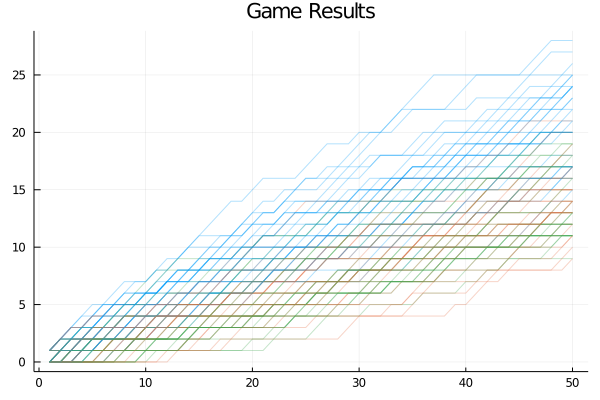

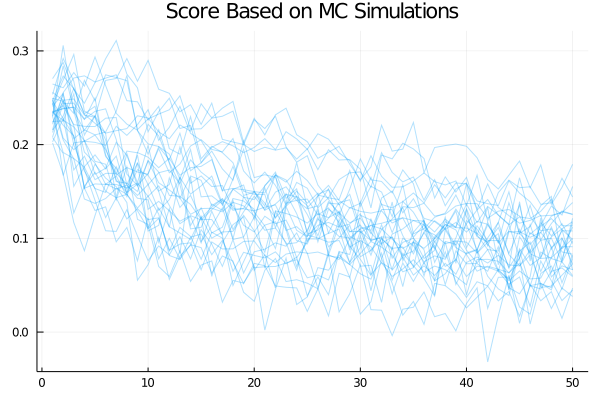

first win: 21.4+-3.538945878511635
ties: 14.433333333333334+-2.8488755595889033
second win: 14.166666666666666+-3.1413080224572094


In [131]:
simulate_game(2, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:34
Progress: 100%|█████████████████████████████████████████| Time: 0:20:37
Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:37
Progress: 100%|█████████████████████████████████████████| Time: 0:20:33
Progress: 100%|█████████████████████████████████████████| Time: 0:20:48
Progress: 100%|█████████████████████████████████████████| Time: 0:20:33
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:59
Progress: 100%|█████████████████████████████████████████| Time: 0:20:51
Progress: 100%|█████████████████████████████████████████| Time: 0:20:29
Progress: 100%|█████████████████████████████████████████| Time: 

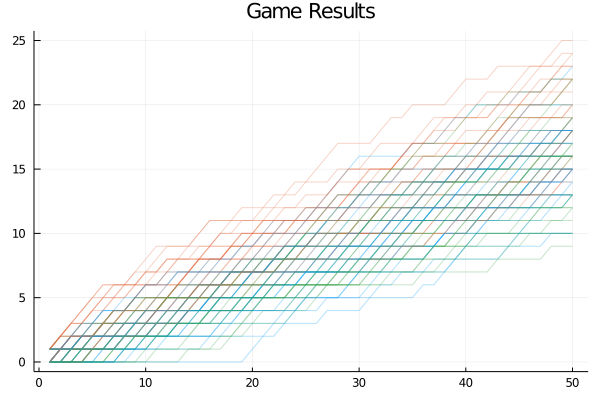

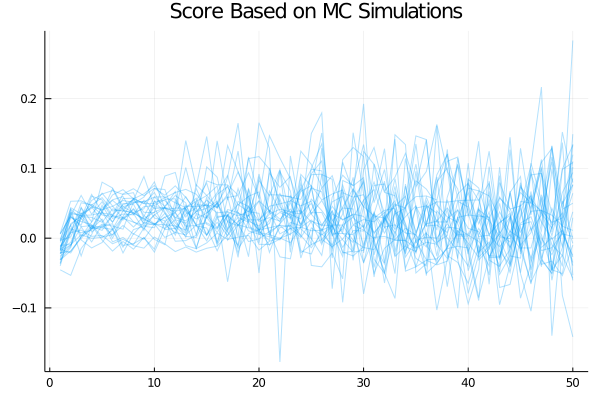

first win: 15.833333333333334+-2.7926422210359565
ties: 19.0+-3.2905297760233916
second win: 15.166666666666666+-3.5630608048208456


In [127]:
simulate_game(2, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:23
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:23
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:27
Progress: 100%|█████████████████████████████████████████| Time: 0:20:27
Progress: 100%|█████████████████████████████████████████| Time: 0:20:25
Progress: 100%|█████████████████████████████████████████| Time: 0:20:26
Progress: 100%|█████████████████████████████████████████| Time: 0:20:23
Progress: 100%|█████████████████████████████████████████| Time: 0:20:24
Progress: 100%|█████████████████████████████████████████| Time: 0:20:28
Progress: 100%|█████████████████████████████████████████| Time: 0:20:24
Progress: 100%|█████████████████████████████████████████| Time: 

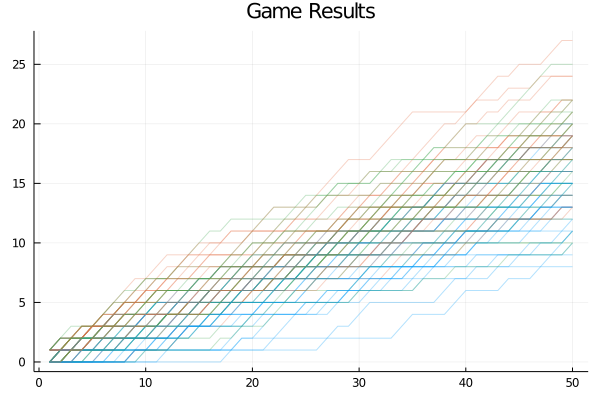

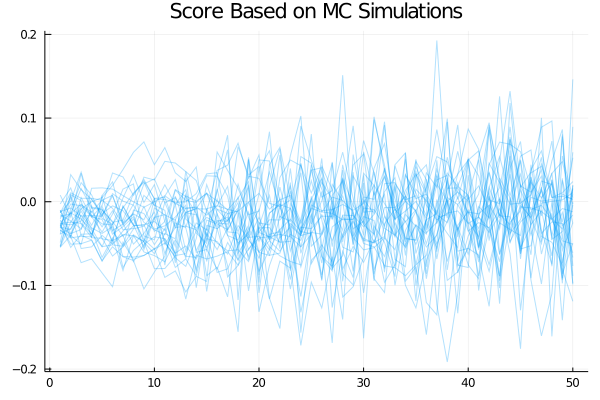

first win: 14.233333333333333+-2.990598294809843
ties: 18.4+-3.5389458785116346
second win: 17.366666666666667+-3.652899965906477


In [128]:
simulate_game(1, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:25:44
Progress: 100%|█████████████████████████████████████████| Time: 0:25:40
Progress: 100%|█████████████████████████████████████████| Time: 0:25:31
Progress: 100%|█████████████████████████████████████████| Time: 0:25:40
Progress: 100%|█████████████████████████████████████████| Time: 0:25:31
Progress: 100%|█████████████████████████████████████████| Time: 0:25:36
Progress: 100%|█████████████████████████████████████████| Time: 0:25:36
Progress: 100%|█████████████████████████████████████████| Time: 0:25:32
Progress: 100%|█████████████████████████████████████████| Time: 0:25:37
Progress: 100%|█████████████████████████████████████████| Time: 0:25:34
Progress: 100%|█████████████████████████████████████████| Time: 0:25:43
Progress: 100%|█████████████████████████████████████████| Time: 0:25:38
Progress: 100%|█████████████████████████████████████████| Time: 0:26:36
Progress: 100%|█████████████████████████████████████████| Time: 

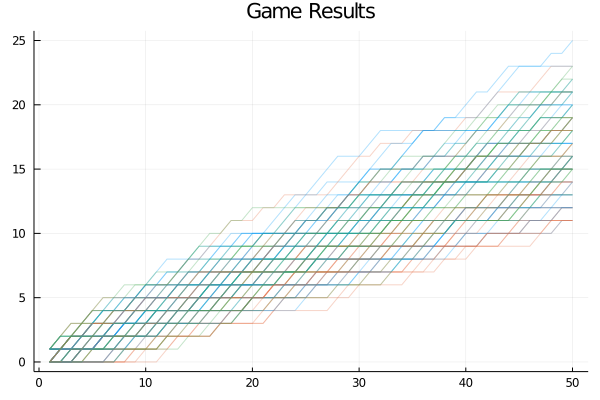

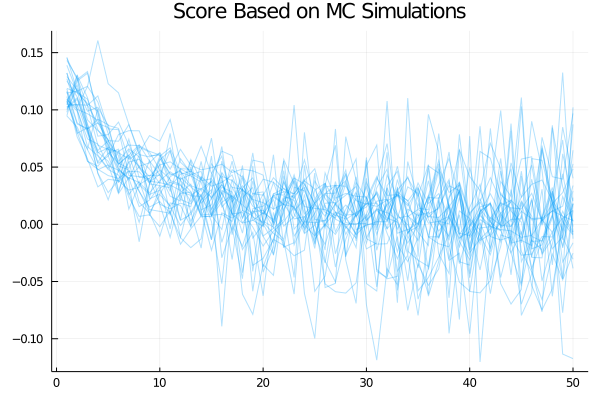

first win: 17.0+-3.723179953415795
ties: 15.033333333333333+-3.2322014845584133
second win: 17.966666666666665+-2.6455340811852426


In [129]:
simulate_game(2, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:26:06
Progress: 100%|█████████████████████████████████████████| Time: 0:26:12
Progress: 100%|█████████████████████████████████████████| Time: 0:26:04
Progress: 100%|█████████████████████████████████████████| Time: 0:26:11
Progress: 100%|█████████████████████████████████████████| Time: 0:26:18
Progress: 100%|█████████████████████████████████████████| Time: 0:26:09
Progress: 100%|█████████████████████████████████████████| Time: 0:26:02
Progress: 100%|█████████████████████████████████████████| Time: 0:26:17
Progress: 100%|█████████████████████████████████████████| Time: 0:26:05
Progress: 100%|█████████████████████████████████████████| Time: 0:26:12
Progress: 100%|█████████████████████████████████████████| Time: 0:26:04
Progress: 100%|█████████████████████████████████████████| Time: 0:26:18
Progress: 100%|█████████████████████████████████████████| Time: 0:26:10
Progress: 100%|█████████████████████████████████████████| Time: 

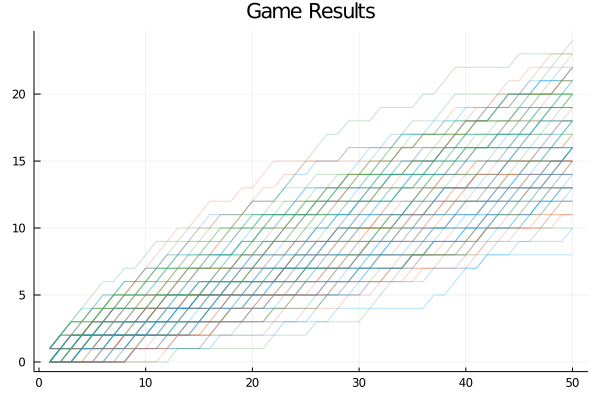

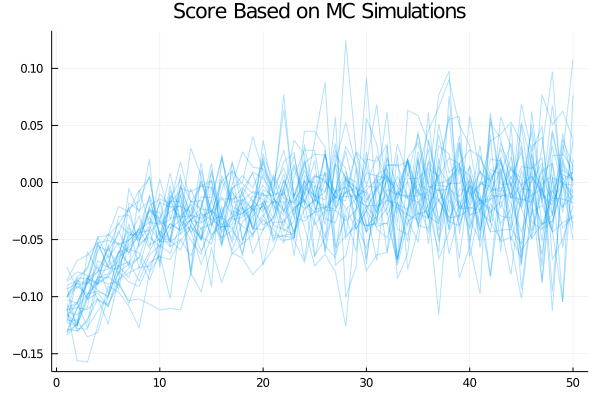

first win: 15.833333333333334+-3.444969679395454
ties: 16.0+-3.6577739603244463
second win: 18.166666666666668+-3.1082019786735042


In [130]:
simulate_game(2, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:32
Progress: 100%|█████████████████████████████████████████| Time: 0:15:20
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:19
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:15:18
Progress: 100%|█████████████████████████████████████████| Time: 0:16:04
Progress: 100%|█████████████████████████████████████████| Time: 0:16:09
Progress: 100%|█████████████████████████████████████████| Time: 0:15:57
Progress: 100%|█████████████████████████████████████████| Time: 0:15:00
Progress: 100%|█████████████████████████████████████████| Time: 0:14:54
Progress: 100%|█████████████████████████████████████████| Time: 0:14:57
Progress: 100%|█████████████████████████████████████████| Time: 0:14:53
Progress: 100%|█████████████████████████████████████████| Time: 

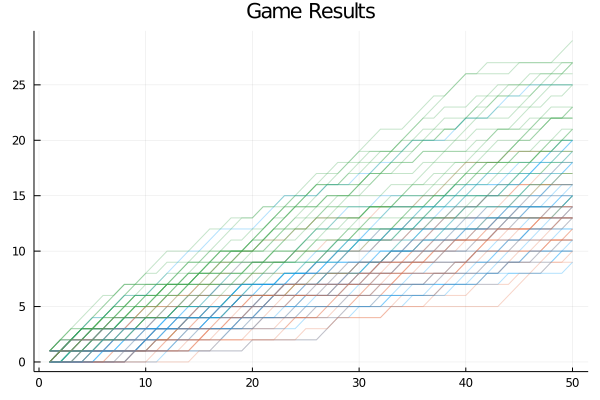

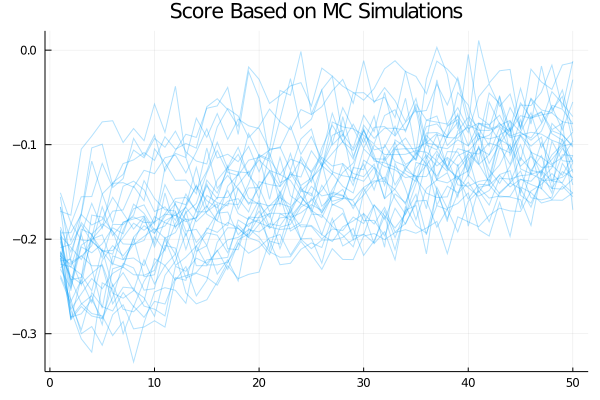

first win: 14.833333333333334+-3.7146804135366267
ties: 13.466666666666667+-2.37419072721536
second win: 21.7+-3.869865898059714


In [132]:
simulate_game(0, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:21
Progress: 100%|█████████████████████████████████████████| Time: 0:20:00
Progress: 100%|█████████████████████████████████████████| Time: 0:20:02
Progress: 100%|█████████████████████████████████████████| Time: 0:20:01
Progress: 100%|█████████████████████████████████████████| Time: 0:20:03
Progress: 100%|█████████████████████████████████████████| Time: 0:20:00
Progress: 100%|█████████████████████████████████████████| Time: 0:20:03
Progress: 100%|█████████████████████████████████████████| Time: 0:20:12
Progress: 100%|█████████████████████████████████████████| Time: 0:20:08
Progress: 100%|█████████████████████████████████████████| Time: 0:20:05
Progress: 100%|█████████████████████████████████████████| Time: 0:20:05
Progress: 100%|█████████████████████████████████████████| Time: 0:20:08
Progress: 100%|█████████████████████████████████████████| Time: 0:20:10
Progress: 100%|█████████████████████████████████████████| Time: 

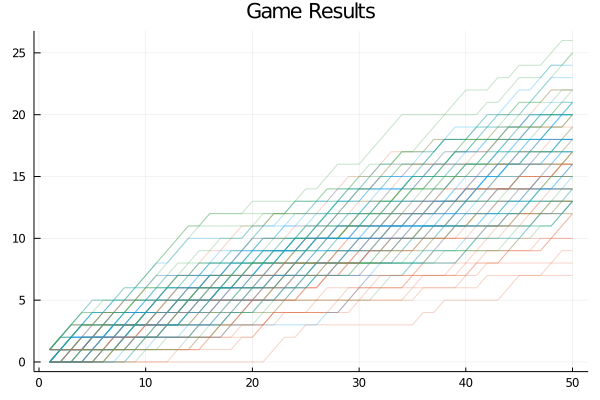

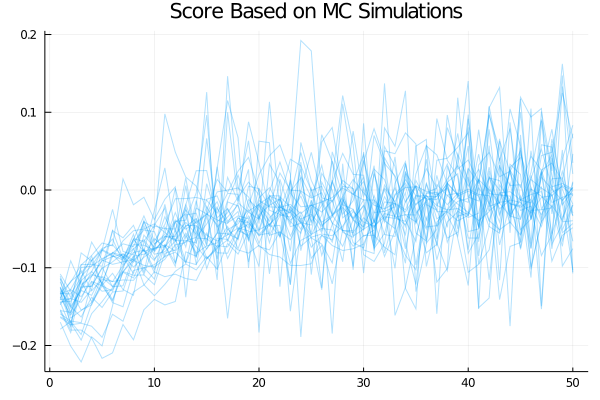

first win: 17.666666666666668+-2.97499154833147
ties: 14.533333333333333+-3.5982115608704284
second win: 17.8+-4.063292363045786


In [133]:
simulate_game(3, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:23:30
Progress: 100%|█████████████████████████████████████████| Time: 0:23:26
Progress: 100%|█████████████████████████████████████████| Time: 0:23:28
Progress: 100%|█████████████████████████████████████████| Time: 0:23:25
Progress: 100%|█████████████████████████████████████████| Time: 0:23:31
Progress: 100%|█████████████████████████████████████████| Time: 0:23:18
Progress: 100%|█████████████████████████████████████████| Time: 0:23:12
Progress: 100%|█████████████████████████████████████████| Time: 0:23:12
Progress: 100%|█████████████████████████████████████████| Time: 0:23:15
Progress: 100%|█████████████████████████████████████████| Time: 0:23:16
Progress: 100%|█████████████████████████████████████████| Time: 0:23:16
Progress: 100%|█████████████████████████████████████████| Time: 0:23:34
Progress: 100%|█████████████████████████████████████████| Time: 0:23:19
Progress: 100%|█████████████████████████████████████████| Time: 

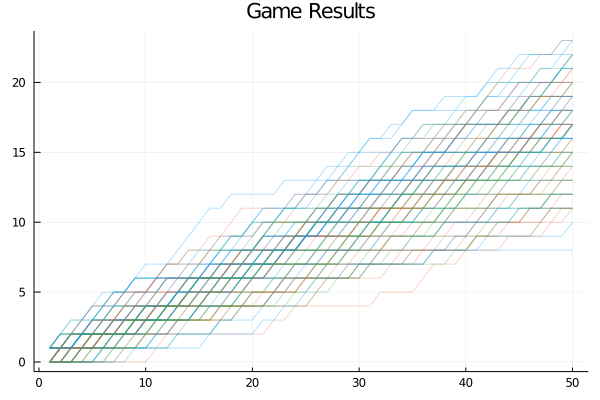

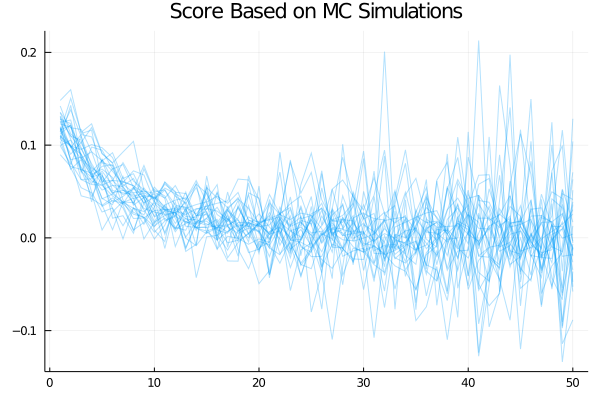

first win: 17.333333333333332+-3.7077117521163383
ties: 16.433333333333334+-3.410767264609729
second win: 16.233333333333334+-3.2021903423290983


In [25]:
simulate_game(3, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:32:15
Progress: 100%|█████████████████████████████████████████| Time: 0:30:12
Progress: 100%|█████████████████████████████████████████| Time: 0:46:27
Progress: 100%|█████████████████████████████████████████| Time: 0:37:07
Progress: 100%|█████████████████████████████████████████| Time: 0:29:03
Progress: 100%|█████████████████████████████████████████| Time: 0:28:44
Progress: 100%|█████████████████████████████████████████| Time: 0:28:48
Progress: 100%|█████████████████████████████████████████| Time: 0:28:37
Progress: 100%|█████████████████████████████████████████| Time: 0:28:46
Progress: 100%|█████████████████████████████████████████| Time: 0:28:53
Progress: 100%|█████████████████████████████████████████| Time: 0:28:46
Progress: 100%|█████████████████████████████████████████| Time: 0:28:44
Progress: 100%|█████████████████████████████████████████| Time: 0:28:47
Progress: 100%|█████████████████████████████████████████| Time: 

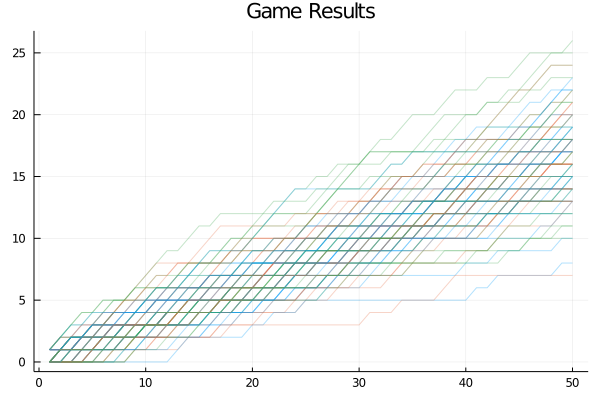

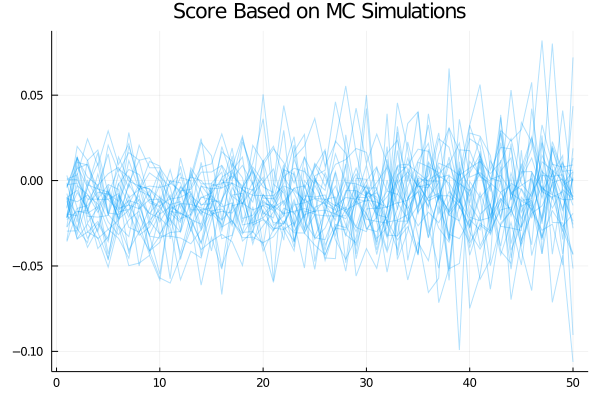

first win: 16.366666666666667+-3.4986039908880047
ties: 16.566666666666666+-3.4309276249749265
second win: 17.066666666666666+-4.298623142302687


In [24]:
simulate_game(3, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:08:49
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:37
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:41
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 0:08:40
Progress: 100%|█████████████████████████████████████████| Time: 0:08:42
Progress: 100%|█████████████████████████████████████████| Time: 0:08:41
Progress: 100%|█████████████████████████████████████████| Time: 0:08:43
Progress: 100%|█████████████████████████████████████████| Time: 0:08:38
Progress: 100%|█████████████████████████████████████████| Time: 0:08:39
Progress: 100%|█████████████████████████████████████████| Time: 

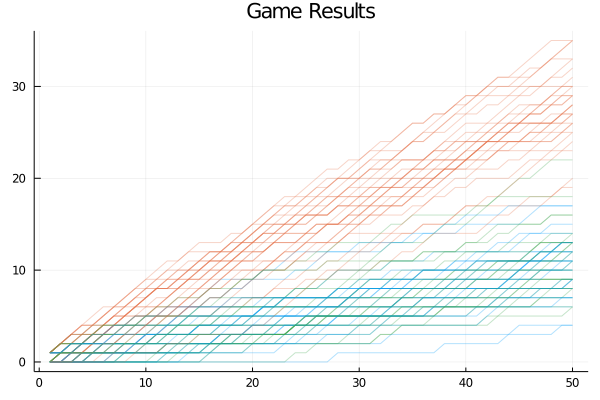

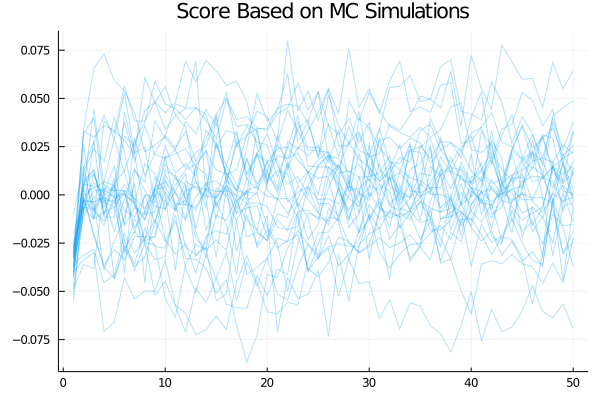

first win: 10.6+-3.3176643217366246
ties: 28.2+-3.9688441816139663
second win: 11.2+-3.6521132285955704


In [26]:
simulate_game(1, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:13:19
Progress: 100%|█████████████████████████████████████████| Time: 0:13:21
Progress: 100%|█████████████████████████████████████████| Time: 0:13:18
Progress: 100%|█████████████████████████████████████████| Time: 0:13:22
Progress: 100%|█████████████████████████████████████████| Time: 0:13:17
Progress: 100%|█████████████████████████████████████████| Time: 0:13:17
Progress: 100%|█████████████████████████████████████████| Time: 0:13:21
Progress: 100%|█████████████████████████████████████████| Time: 0:13:17
Progress: 100%|█████████████████████████████████████████| Time: 0:13:20
Progress: 100%|█████████████████████████████████████████| Time: 0:13:20
Progress: 100%|█████████████████████████████████████████| Time: 0:13:19
Progress: 100%|█████████████████████████████████████████| Time: 0:13:21
Progress: 100%|█████████████████████████████████████████| Time: 0:13:19
Progress: 100%|█████████████████████████████████████████| Time: 

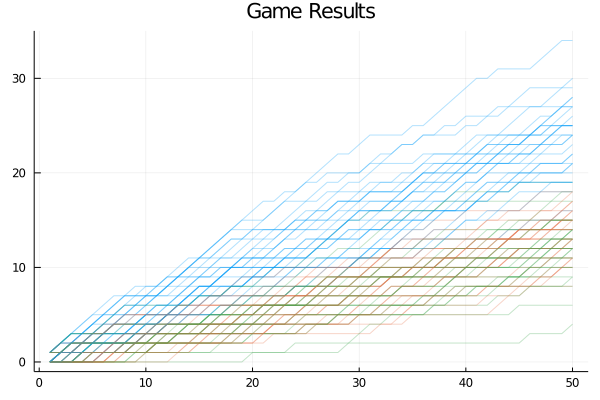

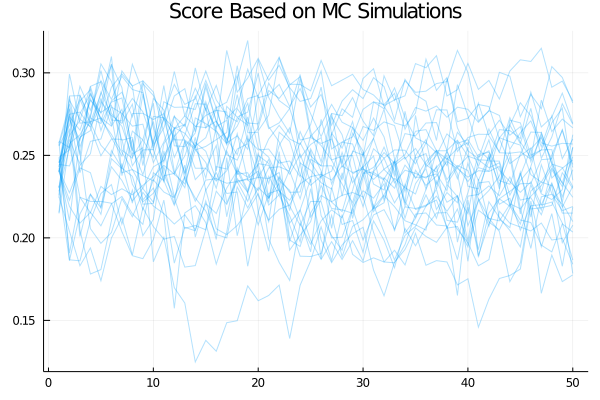

first win: 23.933333333333334+-3.9647875390599507
ties: 13.6+-2.513412297914997
second win: 12.466666666666667+-3.2561171432512546


In [27]:
simulate_game(2, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:18:28
Progress: 100%|█████████████████████████████████████████| Time: 0:17:58
Progress: 100%|█████████████████████████████████████████| Time: 0:18:00
Progress: 100%|█████████████████████████████████████████| Time: 0:18:09
Progress: 100%|█████████████████████████████████████████| Time: 0:18:02
Progress: 100%|█████████████████████████████████████████| Time: 0:18:02
Progress: 100%|█████████████████████████████████████████| Time: 0:18:01
Progress: 100%|█████████████████████████████████████████| Time: 0:17:57
Progress: 100%|█████████████████████████████████████████| Time: 0:17:58
Progress: 100%|█████████████████████████████████████████| Time: 0:18:18
Progress: 100%|█████████████████████████████████████████| Time: 0:17:54
Progress: 100%|█████████████████████████████████████████| Time: 0:17:55
Progress: 100%|█████████████████████████████████████████| Time: 0:18:01
Progress: 100%|█████████████████████████████████████████| Time: 

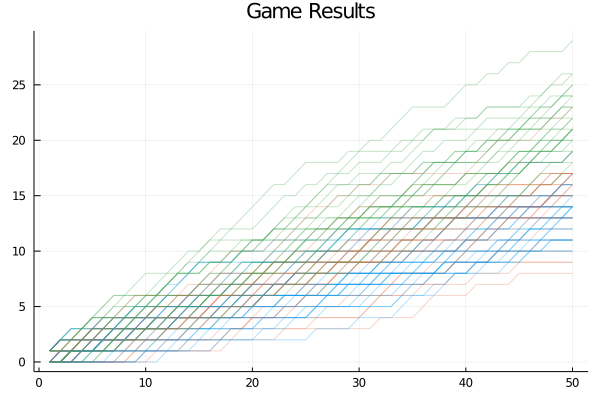

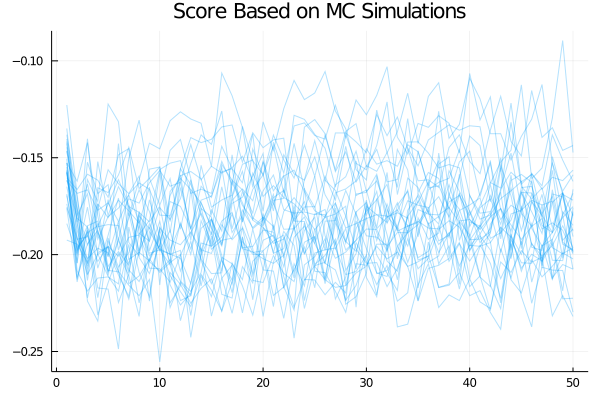

first win: 13.6+-2.14315268897852
ties: 14.7+-3.2286433576712192
second win: 21.7+-2.866573107267691


In [28]:
simulate_game(3, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(4, -1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(4, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(4, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(4, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(4, 3, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
simulate_game(4, 4, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

In [ ]:
print("bla")

## Summery
* The history overwrite the prior pretty fast when looking on history
* when adding theory of mind from 0 to 1 the player succeed to exploit the inbalanced prior
* when going towards higher depth's we see that the effect above not working anymore (but the result is going to Nash-EQ). need more expirments
* we need to see how larger then 1 difference in theory of mind parameter affect the results

TODO:
* increase the num of rounds
* adding more example with different levels of theory of mind (2,0) , (0, 2)